# Réseaux convolutionnels pour le traitement de l'image 


## Partie C : Visualisation d'un CNN

Dans ce notebook, on reprend la quasi intégralité du notebook précédent: on a besoin des données et des modèles... Mais on va ensuite se concentrer sur la visualisation de ce qui se passe à l'intérieur: 
- visualisation des couches de convolution
- visualisation des pixels jouant un role dans la décision (= explication post-hoc)


Vincent Guigue

[directement inspiré de:]
Nicolas Baskiotis (nicolas.baskiotis@soronne-univeriste.fr) Benjamin Piwowarski (benjamin.piwowarski@sorbonne-universite.fr) -- MLIA/ISIR, Sorbonne Université

Les objectifs de ce module sont :
* Prise en main des réseaux convolutionnels (CNN)
* Apprentissage d'un CNN
* Introspection d'un CNN

Nous travaillerons dans un premier temps avec les données MNIST puis avec le jeu de données CIFAR d'images de 10 classes.

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader,Dataset,random_split

import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

mps


In [2]:
from pathlib import Path
from IPython.display import display, HTML
from torch.utils.tensorboard import SummaryWriter

TB_PATH = "/tmp/logs/module2"

# TENSORBOARD V2 (outside notebook => Navigateur)
# usage externe de tensorboard: (1) lancer la commande dans une console; (2) copier-coller l'URL dans un navigateur
display(HTML("<h2>Informations</h2><div>Pour visualiser les logs, tapez la commande : </div>"))
print(f"tensorboard --logdir {Path(TB_PATH).absolute()}")
print("Une fois la commande lancer dans la console, copier-coller l'URL dans votre navigateur")


Reusing TensorBoard on port 6007 (pid 47637), started 0:33:35 ago. (Use '!kill 47637' to kill it.)

cpu


In [3]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

root = '/tmp/'
if not os.path.exists(root):
    os.mkdir(root)

# Téléchargement des données + normalisation
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [4]:
# dimension of images (flattened)
HEIGHT,WIDTH = train_set[0][0][0].size()
INPUT_DIM = HEIGHT * WIDTH

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

#On utilise un DataLoader pour faciliter les manipulations, on fixe arbitrairement la taille du mini batch à 32
mnist_train_loader = DataLoader(train_set,batch_size=TRAIN_BATCH_SIZE,shuffle=True)
mnist_test_loader  = DataLoader(test_set,batch_size=TEST_BATCH_SIZE,shuffle=False)

On reprend la même boucle d'apprentissage.


In [5]:
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).float().mean()
    
def train(model,epochs,train_loader,test_loader):
    writer = SummaryWriter(f"{TB_PATH}/{model.name}")
    optim = torch.optim.Adam(model.parameters(),lr=1e-3)    # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()                            # choix loss
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x,y in train_loader:                            # boucle sur les batchs
            optim.zero_grad()
            x,y = x.to(device), y.to(device)                # y doit être un tensor (pas un int)
            yhat = model(x)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        writer.add_scalar('loss/train',cumloss/count,epoch)
        writer.add_scalar('accuracy/train',cumacc/count,epoch)
        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x,y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
                writer.add_scalar('accuracy/test',cumacc/count,epoch)


## Réseau de convolution (CNN) 

Implémentez un réseau avec deux couches initiales de convolution <a href=https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d>**Conv2d**</a>, chacune comportant 16 filtres de taille 5x5. Chaque couche est suivie d'une activation ReLU et d'un <a href=https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d>**max-pooling**</a> de taille 3x3. On gardera un stride de 1 pour les convolutions et le pooling.

Quelle est la taille du tenseur de sortie des couches de convolution ? (vous pouvez consulter ce <a href=https://arxiv.org/pdf/1603.07285.pdf>guide sur l'arithmétique des convolutions</a>).

A la sortie des couches de convolutions, nous avons besoin d'un classifieur fully-connected. Utilisez deux couches de linéaires avec une activation ReLU.


Usuellement, le sous-réseau convolutionnel est stocké dans une variable **self.features** (comme son rôle est d'extraire les features de l'image), et le sous-réseau fully connected dans une variable **self.classifier**. Utilisez cette structure pour la suite afin que votre code soit compatible avec le squelette fourni.

Implémentez la méthode **forward()** du réseau.
Entraînez votre réseau sur MNIST.

In [6]:
class ConvNet(nn.Module):
    def __init__(self,pooling = nn.MaxPool2d): # argument sur le pooling
        super().__init__()
        # Convolution 5*5, 16 filtres
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        # Max pooling 3x3
        self.pool1 = pooling(kernel_size=3, stride=1)
        # Convolution 5*5, 16 filtres
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)
        # Max pooling 3x3
        self.pool2 = pooling(3, 1)
        #initialisation des poids pour éviter des problèmes de gradient
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)

        # 1.Definir une couche linéaire vers une couche cachée 120 
        #   - calculer la dimnesion d'entrée
        # 2.Couche de sortie (lineaire)
        # 3. features = conv + relu+ pool+conv + relu + pool
        # 4. classif = lin1 + relu + lin2 
        ## <CORRECTION>
        self.lin1 = nn.Linear(16*16*16,120)
        self.lin2 = nn.Linear(120, 10)
        
        self.features   = nn.Sequential(self.conv1,nn.ReLU(),self.pool1,self.conv2,nn.ReLU(),self.pool2)
        self.classifier = nn.Sequential(self.lin1,nn.ReLU(),self.lin2)
        ## </CORRECTION>
        
    def forward(self, x):
        x = self.features(x)    # passage dans les convolutions
        x = self.classifier(x.view(x.size(0), -1)) # classification (après remise en forme)
        return x
convnet=ConvNet().to(device)
convnet.name="1stConv-"+time.asctime()
convnet_avg = ConvNet(nn.AvgPool2d).to(device)
convnet_avg.name="1stConv-pool-"+time.asctime()

In [7]:
# 2 lignes de code = appel à la fonction d'entrainement
# 35 minutes sur mon portable (GPU désactivé)

# normalement dans ce notebook, les modèles existent déjà: il suffit de les charger !

# notebook.display()
# n_epoch = 20
# train(convnet,     n_epoch, mnist_train_loader, mnist_test_loader)
# train(convnet_avg, n_epoch, mnist_train_loader, mnist_test_loader)


In [8]:
import os

def save_model(model,fichier): # pas de sauvegarde de l'optimiseur ici
      """ sauvegarde du modèle dans fichier """
      state = {'model_state': model.state_dict()}
      torch.save(state,fichier) # pas besoin de passer par pickle
 
def load_model(fichier,model):
      """ Si le fichier existe, on charge le modèle  """
      if os.path.isfile(fichier):
          state = torch.load(fichier)
          model.load_state_dict(state['model_state'])

In [9]:
# sauvegarde du réseau (économie de 30 minutes :)
# ATTENTION: pour que ça marche, il faut que les réseaux soient structurellement identiques... Il vous faut donc ma correction :)
# la classe utilisée est dans model.py dans le répertoire model.

path = "/Users/vguigue/Documents/Cours/deep-nb-bp/sceance-nb/"

# fichier = path+f"model/{convnet.name}"
# save_model(convnet,fichier)

# fichier = path+f"model/{convnet_avg.name}"
# save_model(convnet_avg,fichier)

# vous pouvez utiliser les formules symmétriques pour le chargement

convnet = ConvNet().to(device)
convnet.name ="1stConv-trained"
convnet_avg = ConvNet(nn.AvgPool2d).to(device)
convnet_avg.name ="1stConv_avg-trained"
load_model("model/1stConv-trained", convnet)
load_model("model/1stConv_avg-trained", convnet_avg)




## Visualisation du CNN

Une première manière d'introspecter un CNN est de visualiser les sorties des différentes couches et les filtres associés. Pour cela, on enregistre la sortie de chaque couche d'intérêt lors de la passe forward.
Le code suivant permet d'obtenir cette succession d'images : la première image est l'image originale, chaque colonne correspond à un filtre. Les résultats sont ensuite regroupés par couche de convolution, les trois images dans une même colonne correspondent :1) aux poids de la convolution, 2) la sortie de la couche de convolution, 3) la sortie du pooling.

Qu'observez vous ? Comparez les différences entre un réseau utilisant un max-pooling et un réseau utilisant un <a href="https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html">average pooling</a>. Vous pouvez également faire varier la taille et le nombre de filtres.


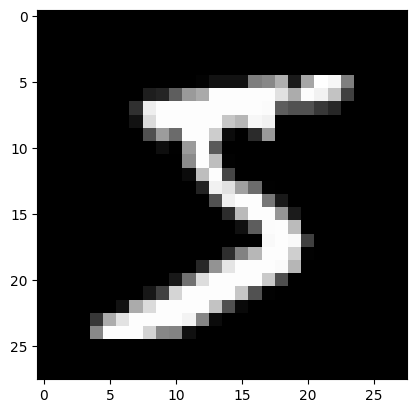

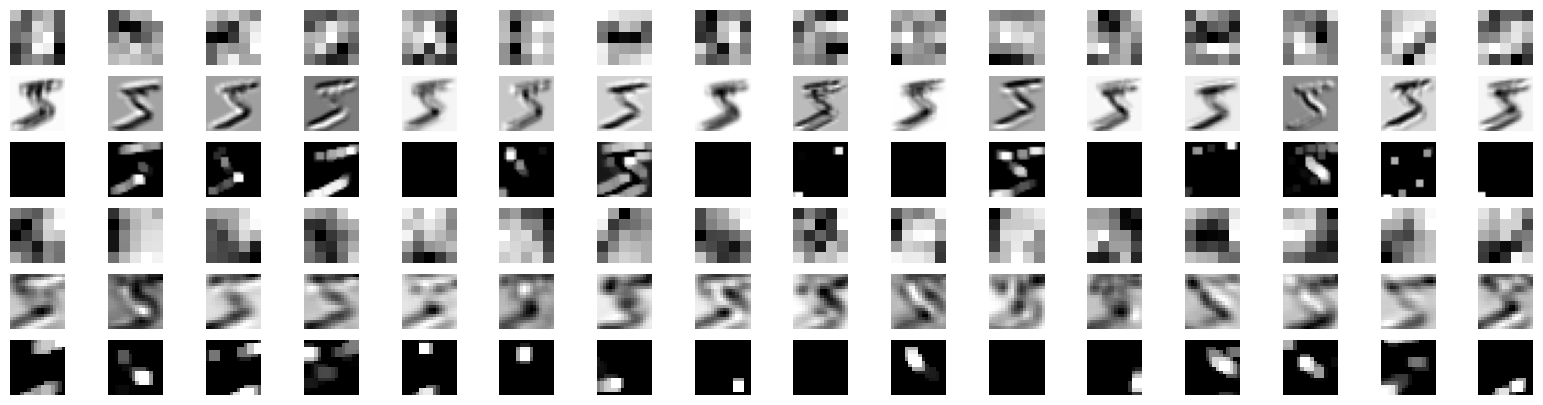

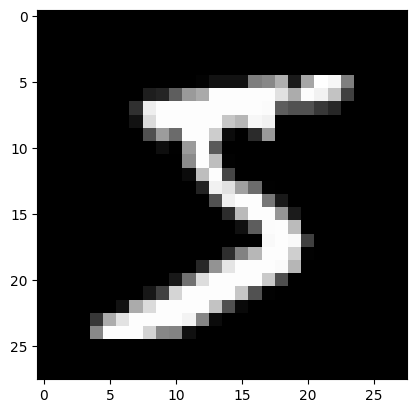

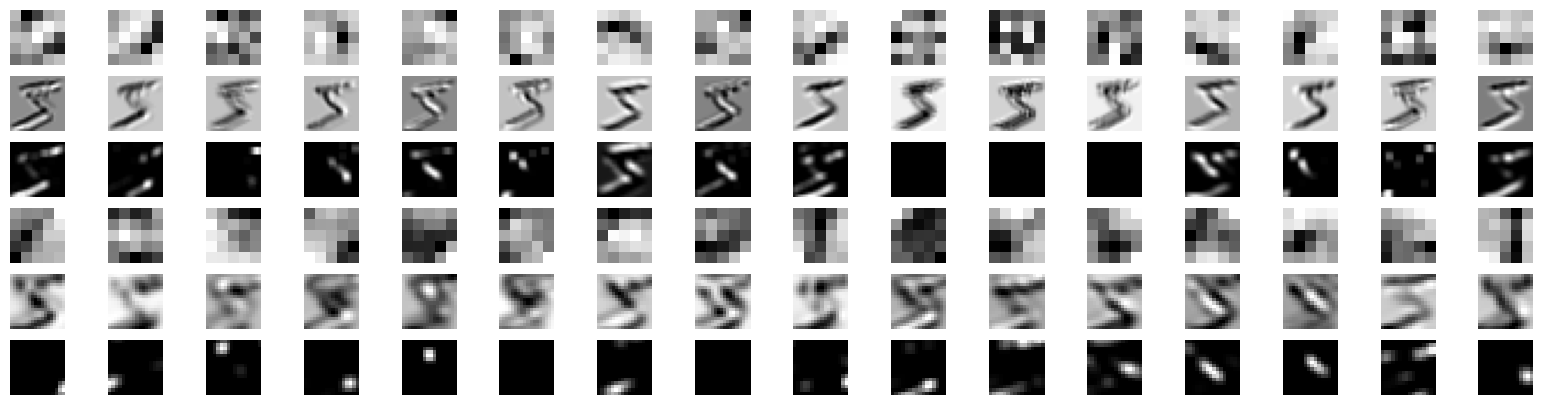

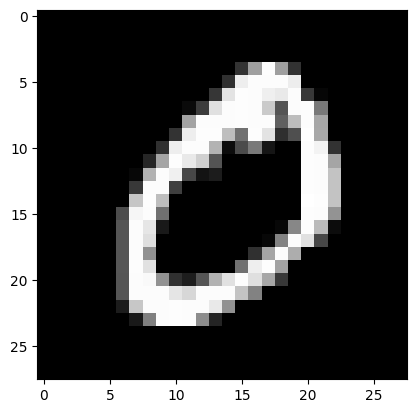

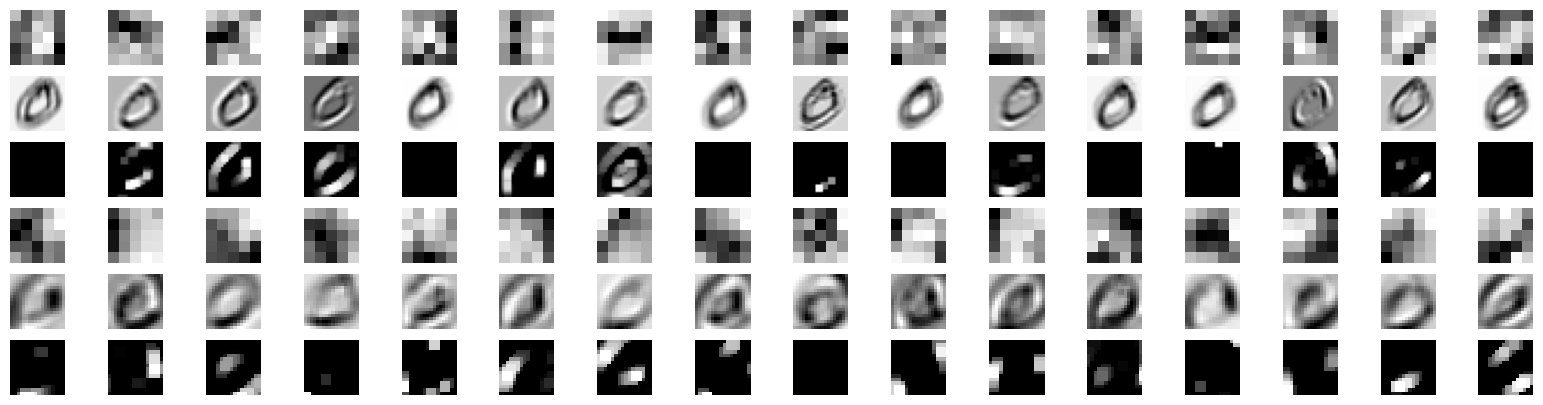

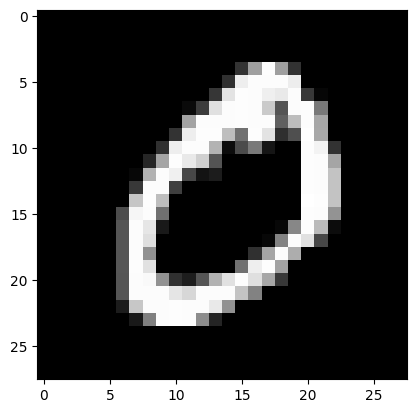

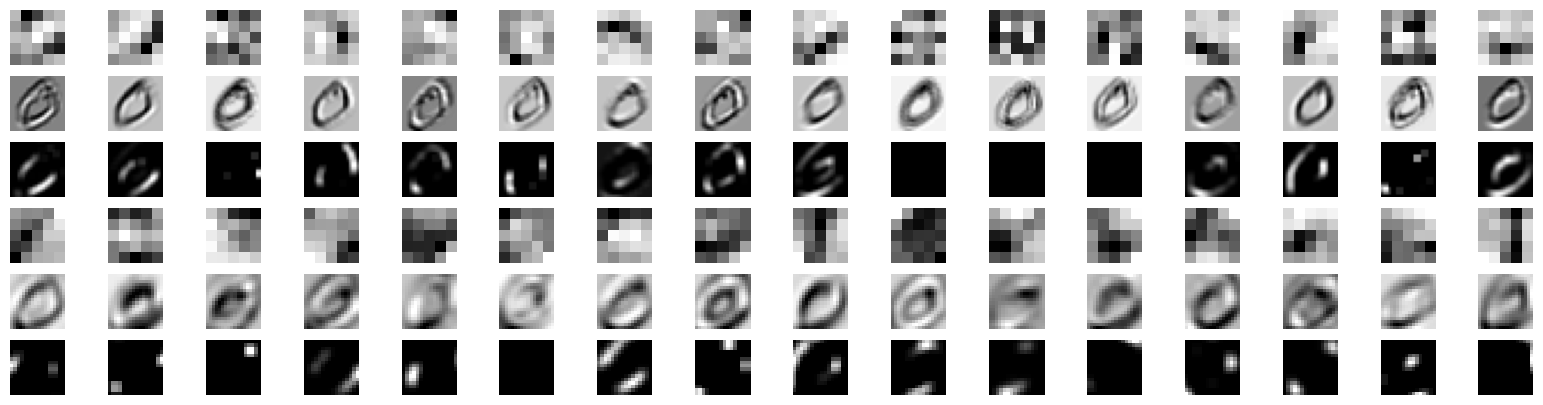

In [10]:
def analyse_conv(model,img,nb_filtres=16):
    x  = img.unsqueeze(0).to(device)
    img_conv = []
    img_pool = []
    # Collecte des données sur les couches en forward = execution pas à pas des couches
    for m in model.features._modules.values(): # parcours des modules de features
        x = m.forward(x)
        if isinstance(m,nn.Conv2d): # pour les modules conv => les poids + la sortie
            img_conv.append((x.squeeze(0),m.weight))
        if isinstance(m,nn.MaxPool2d) or isinstance(m,nn.AvgPool2d): # pour le pooling, juste la sortie du module (pas de poids)
            img_pool.append(x.squeeze(0))
    
    # Partie d'affichage des données collectées
    plt.figure()
    plt.imshow(img.squeeze(0).to('cpu'),cmap='gray') # input (~transpose en 3D)
    # nombre de filtres => affichage des données
    ksmax = min(nb_filtres, max([p[0].size(0) for p in img_conv]))
    fig, axs = plt.subplots(3*len(img_conv),ksmax,figsize=(20,5))
    for i,((img_c,w),img_p) in enumerate(zip(img_conv,img_pool)): # zip = hypothèse 1 conv <=> 1 pool
        # affichage Conv+result+pool => Toutes les 3 lignes
        for j in range(min(nb_filtres,img_c.size(0))):
            axs[3*i,j].imshow(np.array(w[j,0].to('cpu').detach()),cmap="gray") # indice = toutes les 3 lignes
            axs[3*i,j].axis('off')
            axs[3*i+1,j].imshow(np.array(img_c[j].to('cpu').detach()),cmap="gray")                             
            axs[3*i+1,j].axis('off')
        for j in range(min(nb_filtres,img_p.size(0))):
            axs[3*i+2,j].imshow(np.array(img_p[j].to('cpu').detach()),cmap="gray")
            axs[3*i+2,j].axis('off')
    plt.show()
## [[student]]    
analyse_conv(convnet,mnist_train_loader.dataset[0][0]) 
analyse_conv(convnet_avg,mnist_train_loader.dataset[0][0]) 
analyse_conv(convnet,mnist_train_loader.dataset[1][0]) 
analyse_conv(convnet_avg,mnist_train_loader.dataset[1][0])     
## [[/student]]

## Saliency Map

La visualisation des filtres ne permet pas bien de comprendre le rôle de chaque filtre dans la classification. Ils permettent d'extraire des features élémentaires qui combinées ensemble font sens pour un réseau fully-connected mais dont l'interprétation n'est pas évidente pour l'oeil humain.

Une première méthode pour détecter quelles zones de l'image ont le plus impacté la décision sont les cartes de saillance. L'objectif des Saliency Maps est de détecter les pixels d'entrée qui ont le plus impacté la décision. L'idée est d'utiliser le gradient *par rapport* à l'image pour ranker les pixels. En effet, un gradient fort pour un pixel d'entrée indique qu'il faut changer faiblement sa valeur pour que la classe infére change (et a contrario, un gradient nul indique que le pixel n'est pas pris en compte pour la classification selon cette classe).
Les étapes à suivre sont les suivantes :
* le flag *requires_grad* est mis à True pour l'image (pour pouvoir calculer la rétro-propagation)
* une passe forward est faite sur l'image
* le backward est calculé sur le score de sortie de la classe d'intérêt
* On affiche la valeur absolue du gradient  par rapport à l'entrée obtenu. Si l'image à plusieurs canaux, on prend le max de chacun de ces canaux.



In [11]:

def getSaliency(model,img,label):
    model.zero_grad()
    img = img.to(device)
    img.requires_grad = True    # ajout du gradient sur l'image elle-même
                                # idée: + gd gradient = + fort impact sur la décision
    img.grad = None
    outputs = nn.Softmax(dim=1)(model(img.unsqueeze(0)))    # ATTENTION, le softmax est dans la loss, pas dans le réseau 
                                                            # => il faut le remettre à la main pour que ça marche
    output=outputs[0,label]     # focalisation sur la vérité terrain
    output.backward()           # calcul des gradients associés à cette classe seulement
    sal=img.grad.abs()          # récupération du gradient sur l'image (+abs)
    if sal.dim()>2:
        sal=torch.max(sal,dim=0)[0]
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img.detach().cpu().squeeze(0),cmap="gray")
    fig.add_subplot(1, 2, 2)
    plt.imshow(sal.to('cpu'),cmap="seismic",interpolation="bilinear")
    return sal


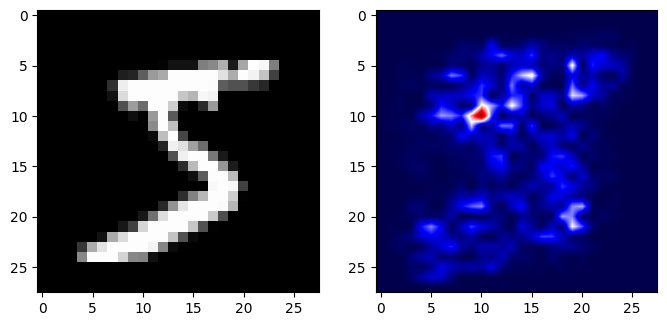

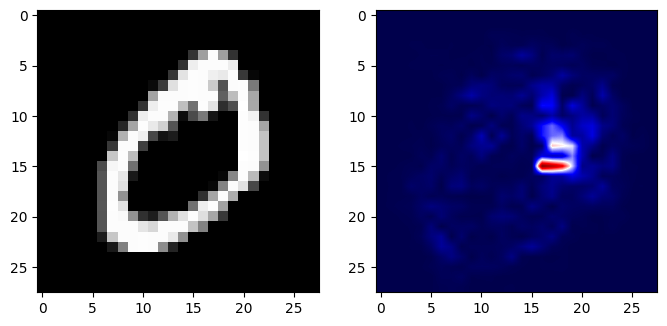

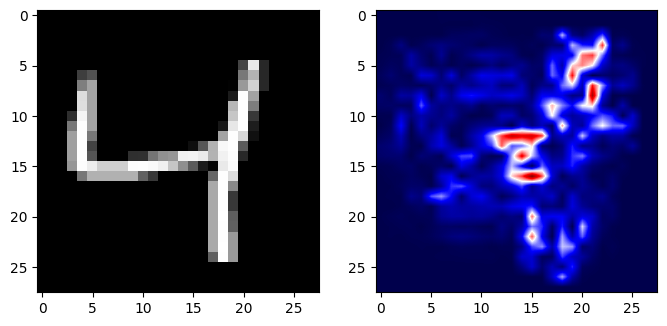

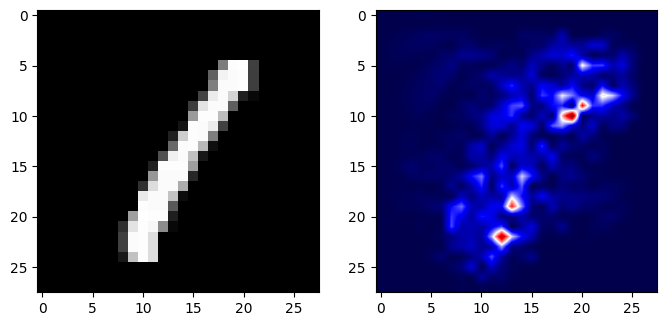

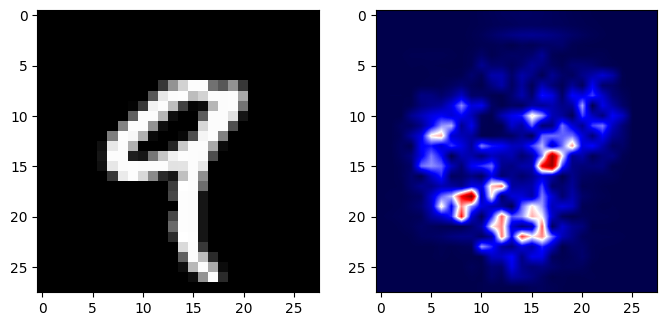

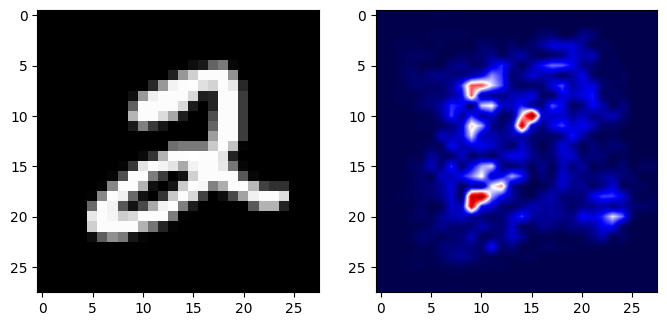

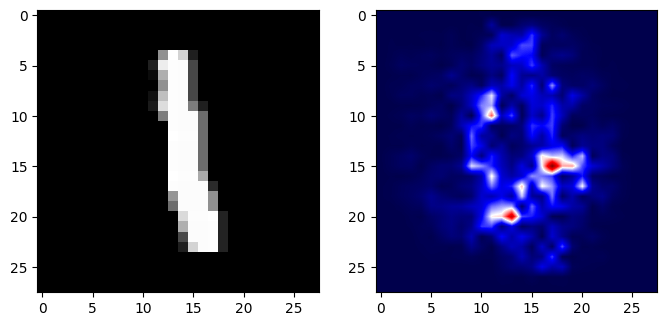

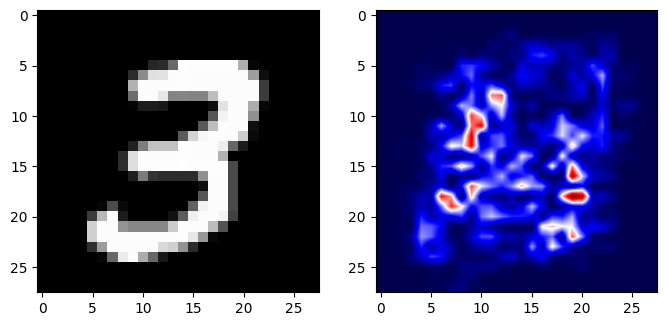

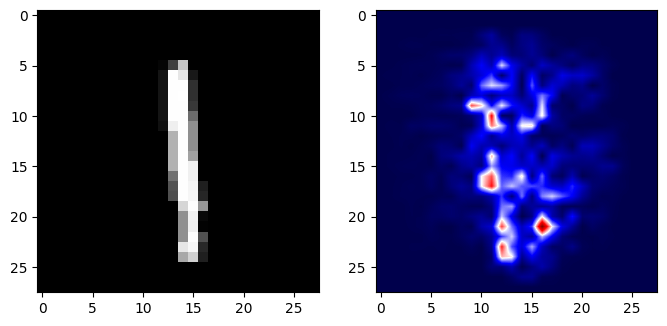

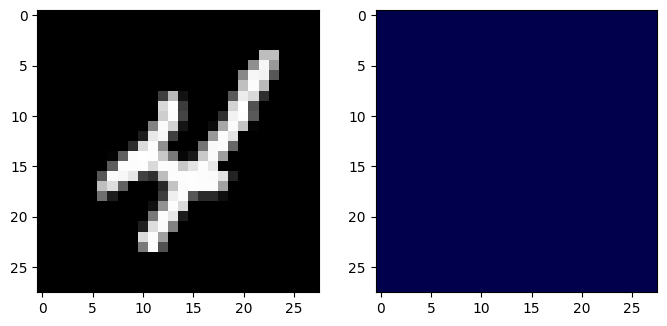

In [12]:
for i in range(10):
    x,y = mnist_train_loader.dataset[i]
    getSaliency(convnet,x,y)

## Class Activation Maps (CAM)
Une autre technique d'introspection est le Class Activation Maps. Cette technique permet de visualiser quels sont les régions qui ont fait le plus réagir les différents filtres qui ont servis à la classification. Elle part de la constatation que la sortie d'un filtre de la dernière couche convolutionnelle indique spatialement quelles sont les régions de l'image qui ont fait réagir le filtre (la sortie est généralement de taille plus petite - *downscalé* - mais on peut la mettre à l'échelle). Cependant, il est difficile d'analyser avec la succession des couches non-linéaires en aval le rôle de chaque sortie convolutionnelle dans le processus de classification. Cependant, un réseau plus simple - uniquement linéaire par exemple - permettrait de donner une indication à l'importance de chaque filtre (au prix d'une erreur plus grosse en classification). 
Cette technique nécessite donc la modification des dernières couches du réseau de la manière suivante : 
* un pooling de moyennage globale (un average pooling de la taille de l'image) est appliquée à chaque filtre de convolution de la dernière couche convolutionnelle : seul le signal moyen de chaque filtre est retenu, sans plus aucune information spatiale.
* un réseau linéaire est ensuite utilisé du nombre de filtres vers le nombre de classes qui va permettre de mettre en évidence l'intérêt de chaque filtre dans la classification.

Le réseau ainsi modifié est fine-tuné sur le corpus. L'Activation Map est obtenu en sommant les sorties de la dernière couche convolutionnelle pondérées par les poids du réseau linéaire. 

Le code ci-dessous permet d'obtenir une telle carte pour une image et un modèle donné.

Modifiez  tout d'abord votre réseau en remplaçant le classifieur par un average pooling global puis un linéaire.  Ré-entraînez ensuite les couches modifiées - sans toucher aux poids de l'extraction de features. Visualisez les cartes sur des exemples. 

In [ ]:
## Permet de mettre à  True/False tous les requires_grad des paramètres du réseau
def set_parameter_requires_grad(model,b):
    for p in model.parameters():
        p.requires_grad = b
def generate_cam(model,input_image,target_class=None):
    ## Calcul du forward sur l'image
    with torch.no_grad():
        input_image=input_image.to(device)
        x = model.features(input_image) # extraction features seules (idem premier réseau)
        out=model(input_image)          # sortie = tout le réseau (nouvelle couche de décision, cf ci-dessous)
        out=torch.nn.functional.softmax(out,-1)
    if target_class is None:
        target_class = torch.max(out,dim=-1)[1].item()
    print("target_class",target_class)
    ## Récupération des poids du linéaire
    weights = list(model.classifier._modules.values())[-1].weight.data  # dernière couche
    fig = plt.figure(figsize=(16, 8))
    fig.add_subplot(1,2, 1)
    img=input_image.to("cpu") ##*torch.tensor(std).view(3,1,1)+torch.tensor(mean).view(3,1,1)
    #img=torch.nn.functional.interpolate(img, size=(244, 244), mode="bilinear", align_corners=False)
    plt.imshow(img.cpu().squeeze(0).permute(1,2,0))
    ## Calcul de CAM
    y=x*weights[target_class].view(1,-1,1,1)
    y=(y.sum(1))  
    fig.add_subplot(1, 2, 2)
    #y=torch.nn.functional.interpolate(y.unsqueeze(0),size=(244,244),mode="bilinear",align_corners=False)
    plt.imshow(y.cpu().squeeze(),cmap="bwr",vmax=4,vmin=-4)
    plt.show()


In [ ]:
## Modifiez votre réseau ici et ré-entrainez le
## 
set_parameter_requires_grad(convnet,False) # on repart de convnet
convnet.classifier = nn.Sequential(torch.nn.Unflatten(1,(16,16,16)),torch.nn.AvgPool2d(16,1),torch.nn.Flatten(1),torch.nn.Linear(16,10)) # modification de la couche de classif
# remise en forme des filtres + moyennage + remise à plat + décision
train(convnet,10,mnist_train_loader,mnist_test_loader)
## 

In [ ]:
mnist_batch, mnist_class = next(iter(mnist_train_loader))
mnist_features = convnet.features.forward(mnist_batch.to(device))

In [ ]:
mnist_batch, mnist_class = next(iter(mnist_train_loader))
mnist_features = convnet.features.forward(mnist_batch.to(device))
for i in range(10):
    generate_cam(convnet,mnist_batch[i].unsqueeze(0),mnist_class[i])


# Construction du sujet à partir de la correction

In [1]:
### <CORRECTION> ###
import re
# transformation de cet énoncé en version étudiante

fname = "2_2-CNN-visu-corr.ipynb" # ce fichier
fout  = fname.replace("-corr","")

# print("Fichier de sortie: ", fout )

f = open(fname, "r")
txt = f.read()
 
f.close()


f2 = open(fout, "w")
f2.write(re.sub("<CORRECTION>.*?(</CORRECTION>)"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###